In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt

import re
import seaborn as sns
import datetime
from datetime import timedelta

Load data.

- Station Data
- Cleaned data of bike trips
- Cleaned data of YVR weather data

In [2]:
data_folder = 'data'
pickle_folder = 'pickle'

#load station data
station_info_df = pd.read_csv(data_folder + '/' + 'station_data.csv', dtype={'id': str, 'name': str, 'lat': float, 'lon': float, 'total_slots':int})

def load_pickle(url):
    '''
    Function to load pickle file
    '''
    infile = open(url, 'rb')
    data = pickle.load(infile)
    infile.close()
    return data

filename = 'mobi_cleaned.pkl'
combined_df = load_pickle(pickle_folder + '/' + filename)

filename = 'YVR_wxdata.pkl'
weather_df = load_pickle(pickle_folder + '/' + filename)

    

###  Start of DF assembly

In [3]:
date_range_ind = pd.date_range(start=datetime.date(2017, 1, 1), end=datetime.date(2019, 3, 31), freq='D')

In [4]:
def average_df(colname, df, time_freq='D'):
    '''
    Function to calculate the average based on the time frequency.
    '''
    
    target_df = df[colname]
    target_df.index = df['Date']

    output_target_df = target_df.resample(time_freq).sum()/target_df.resample(time_freq).count()
    
    return(output_target_df)


def max_df(colname, df, time_freq='D'):
    '''
    Function to calculate the average based on the time frequency.
    '''
    
    target_df = df[colname]
    target_df.index = df['Date']

    output_target_df = target_df.resample(time_freq).max()
       
    return(output_target_df)


def min_df(colname, df, time_freq='D'):
    '''
    Function to calculate the average based on the time frequency.
    '''
    
    target_df = df[colname]
    target_df.index = df['Date']

    output_target_df = target_df.resample(time_freq).min()

    return(output_target_df)


def sum_df(colname, df, time_freq='D'):
    '''
    Function to calculate the average based on the time frequency.
    '''
    
    target_df = df[colname]
    target_df.index = df['Date']

    output_target_df = target_df.resample(time_freq).sum()
    return(output_target_df)


In [5]:
df = pd.DataFrame({'count': [1] * len(combined_df['Departure'])})
df.index = combined_df['Departure']

df = df.resample('D').count()
#df['AVG_TEMP'] = temp_daily_avg_df
df = df[:-1]


var_list = ['CO', 'NO', 'NO2', 'O3', 'PM25', 'SO2', 'PM10', 'WSPD_SCLR',
       'WDIR_SCLR', 'WSPD_VECT', 'WDIR_VECT', 'TEMP_MEAN', 'ATM_PRESS_1HR',
       'HUMIDITY', 'RAD_TOTAL', 'PRECIP_TOTAL']


for var in var_list:
    df[('AVG_'+var)] = average_df(var, weather_df)

for var in ['TEMP_MEAN']:
    df[('MAX_'+var)] = max_df(var, weather_df)
    
for var in ['TEMP_MEAN']:
    df[('MIN_'+var)] = min_df(var, weather_df)

for var in ['TEMP_MEAN']:
    df[('RANGE_'+var)] = max_df(var, weather_df) - min_df(var, weather_df) 

    
df['SUM_PRECIP_TOTAL'] = sum_df('PRECIP_TOTAL', weather_df)

### Plotting the Correlation Matrix

First scale the data before doing the correlation matrix, or else it will be skewed.

The variables that are highly correlated to the trip counts in a day is the average temperature and the average solar irradiance. There is a theoretical equation in which the total and average solar irradiance can be calcuated, but this variables fluctuates with cloud cover and aerosol concentration in the air. 

From a practical perspective, temperature and precipitation are the only variables where we can reasonable rely on if we want to use forecast data from a weather model. 

For this project, I am going to make an assumption that the observation model that we use for the testing and validation are the same as the forecast data that is generated from a weather model. Usually, the data from a weather model that are 2-3 days out are quite reliable.

C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


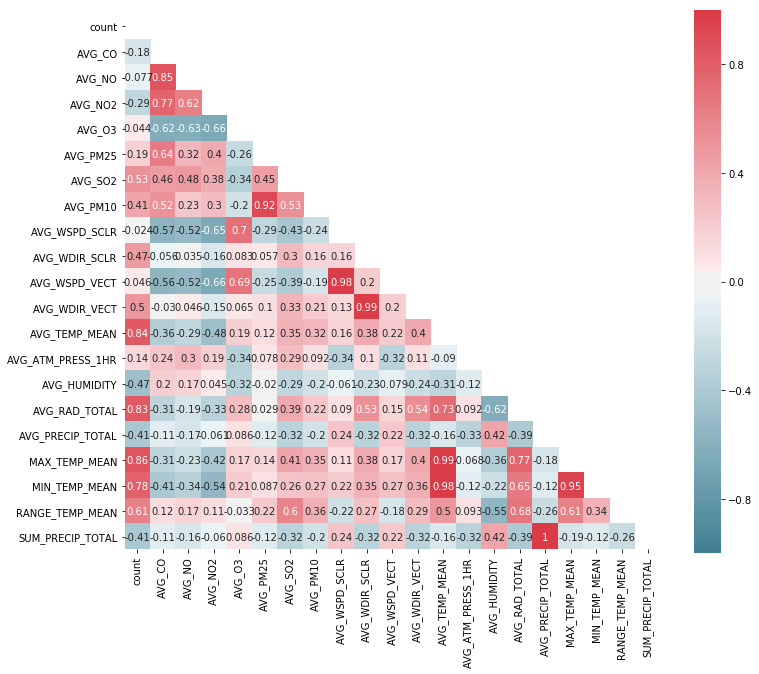

In [6]:
from sklearn.preprocessing import StandardScaler

def scale_data(df):
    scaler = StandardScaler()
    scaler.fit(df)
    scaled_df = scaler.transform(df)
    scaled_df = pd.DataFrame(scaled_df, columns=df.columns, index=df.index)
    return(scaled_df)

#scaled_df = scale_data(df)

plt.figure(figsize=(12,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#cmap = sns.color_palette("coolwarm", 100)

corr_df = scale_data(df).corr()

mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_df, mask = mask, annot=True, cmap=cmap, center=0, vmin=-1.0, vmax=1.0, square=True);

C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


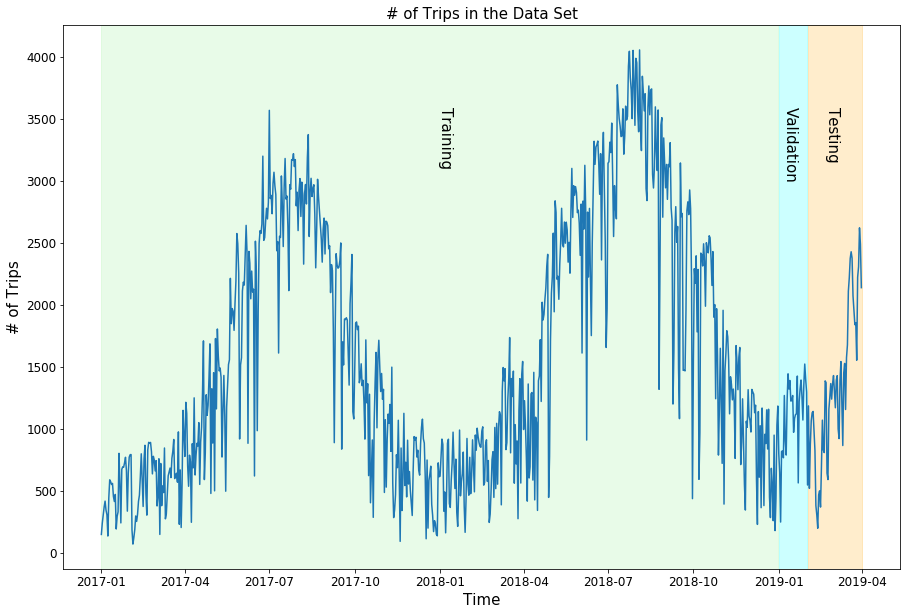

In [7]:
col = 'black'
a = 0.2
font_size_tick=12
plt.figure(figsize=(15,10))
plt.plot(df['count'], label='Count')
plt.xlabel('Time', fontsize=15, color=col)
plt.ylabel('# of Trips', fontsize=15, color=col)
plt.title('# of Trips in the Data Set',  fontsize=15, color=col)
plt.xticks(fontsize=font_size_tick, color=col)
plt.yticks(fontsize=font_size_tick, color=col)
plt.axvspan('2017-01-01', '2018-12-31', color='lightgreen', alpha=a)
plt.axvspan('2019-01-01', '2019-01-31', color='cyan', alpha=a)
plt.axvspan('2019-02-01', '2019-04-01', color='orange', alpha=a)
plt.annotate('Training', ('2017-12-30', 3500), fontsize=15, rotation=270)
plt.annotate('Validation', ('2019-01-05', 3500), fontsize=15, rotation=270)
plt.annotate('Testing', ('2019-02-20', 3500), fontsize=15, rotation=270)
plt.show();

### Adding Additional Features

#### Day of the Week

In [8]:
df['day_of_week']=df.index.to_series().dt.dayofweek

df.loc[df['day_of_week'] == 0, 'day_of_week'] = 'Monday'
df.loc[df['day_of_week'] == 1, 'day_of_week'] = 'Tuesday'
df.loc[df['day_of_week'] == 2, 'day_of_week'] = 'Wednesday'
df.loc[df['day_of_week'] == 3, 'day_of_week'] = 'Thursday'
df.loc[df['day_of_week'] == 4, 'day_of_week'] = 'Friday'
df.loc[df['day_of_week'] == 5, 'day_of_week'] = 'Saturday'
df.loc[df['day_of_week'] == 6, 'day_of_week'] = 'Sunday'

#### Holidays in BC

In [9]:
holiday_list = [datetime.datetime(2017, 1, 1),
    datetime.datetime(2017, 1, 2),
    datetime.datetime(2017, 2, 13),
    datetime.datetime(2017, 4, 14),
    datetime.datetime(2017, 5, 22),
    datetime.datetime(2017, 7, 1),
    datetime.datetime(2017, 8, 7),
    datetime.datetime(2017, 9, 4),
    datetime.datetime(2017, 10, 9),
    datetime.datetime(2017, 11, 10),
    datetime.datetime(2017, 11, 11),
    datetime.datetime(2017, 12, 24),
    datetime.datetime(2017, 12, 25),
    datetime.datetime(2017, 12, 26),
    datetime.datetime(2018, 1, 1),
    datetime.datetime(2018, 2, 12),
    datetime.datetime(2018, 3, 30),
    datetime.datetime(2018, 5, 21),
    datetime.datetime(2018, 7, 1),
    datetime.datetime(2018, 7, 2),
    datetime.datetime(2018, 8, 6),
    datetime.datetime(2018, 9, 3),
    datetime.datetime(2018, 10, 8),
    datetime.datetime(2018, 11, 11),
    datetime.datetime(2018, 11, 12),
    datetime.datetime(2018, 12, 24),
    datetime.datetime(2018, 12, 25),
    datetime.datetime(2018, 12, 26),
    datetime.datetime(2019, 1, 1),
    datetime.datetime(2019, 2, 18)
]
holiday_list = pd.to_datetime(holiday_list)

#convert to 1 and 0
holiday_col = date_range_ind.isin(holiday_list)

df['HOLIDAY'] = holiday_col.astype(int)
df['NOT_HOLIDAY'] = (~(holiday_col)).astype(int)

del holiday_list, holiday_col

#### Add Season

In [10]:
#from stack overflow
#https://stackoverflow.com/questions/16139306/determine-season-given-timestamp-in-python-using-datetime

def season_of_date(date):
    year = str(date.year)
    seasons = {'Spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'Summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'Autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['Spring']:
        return 'Spring'
    if date in seasons['Summer']:
        return 'Summer'
    if date in seasons['Autumn']:
        return 'Autumn'
    else:
        return 'Winter'
    
df['SEASON'] = date_range_ind.map(season_of_date)

#### Add Quarter, Weekday, Weekend


In [11]:
df['QUARTER'] = date_range_ind.quarter.astype(str)

df['Weekday'] = df['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']).astype(int)
df['Weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)

In [12]:
def model_score(model, X_train, X_valid, X_test, y_train, y_valid, y_test):
    import math
    from sklearn.metrics import r2_score, mean_squared_error

    score_output = [
        math.sqrt(mean_squared_error(y_train, model.predict(X_train).round())),
        math.sqrt(mean_squared_error(y_valid, model.predict(X_valid).round())),
        math.sqrt(mean_squared_error(y_test, model.predict(X_test).round())),
        r2_score(y_train, model.predict(X_train).round()),
        r2_score(y_valid, model.predict(X_valid).round()),
        r2_score(y_test, model.predict(X_test).round())
        ]
    
    return (score_output)


def custom_plot_package(model_name, model, X_train, X_valid, X_test, y_train, y_valid, y_test):

    '''
    Outputs plots for train, valid, and test
    
    In addition, it calls the model_score function that calculates the RMSE and R2
    '''
    
    plt.figure(figsize=(10,10))

    X_list = [X_train, X_valid, X_test]
    y_list = [y_train, y_valid, y_test]
    name_list = ['Training', 'Valid', 'Test']
    
    for i in range(3):
        plt.subplot(3,1, (i + 1))
        plt.plot(y_list[i], label='Actual')
        plt.plot(pd.DataFrame(model.predict(X_list[i]), index=y_list[i].index), label='Prediction')
        plt.legend()
        plt.title(model_name + ' - ' + name_list[i])

    model_score_list = model_score(model, X_train, X_valid, X_test, y_train, y_valid, y_test)
    
    return (model_score_list)


def custom_score_display(the_score):
    output_score = pd.DataFrame([the_score])
    output_score.columns = ['Training - RMSE', 'Valid - RMSE', 'Test - RMSE', 'Training - R2', 'Valid - R2', 'Test - R2']
    
    return (output_score)

In [13]:
#Assemble df

X = df.reindex(['AVG_TEMP_MEAN', 'day_of_week', 'SUM_PRECIP_TOTAL', 'MAX_TEMP_MEAN', 'MIN_TEMP_MEAN',
                'HOLIDAY', 'NOT_HOLIDAY', 'SEASON', 'QUARTER', 'Weekday', 'Weekend'], axis=1)

y = df['count']

In [14]:
date_range_train = pd.date_range(start=datetime.date(2017, 1, 1), end=datetime.date(2018, 12, 31), freq='D')
date_range_valid = pd.date_range(start=datetime.date(2019, 1, 1), end=datetime.date(2019, 1, 31), freq='D')
date_range_test = pd.date_range(start=datetime.date(2019, 2, 1), end=datetime.date(2019, 3, 31), freq='D')

X_onehot = pd.get_dummies(X)

X_train = X_onehot.loc[date_range_train]
X_valid = X_onehot.loc[date_range_valid]
X_test = X_onehot.loc[date_range_test]

y_train = y.loc[date_range_train]
y_valid = y.loc[date_range_valid]
y_test = y.loc[date_range_test]

#For Statsmodel OLS
import statsmodels.api as sm
X_onehot_c = sm.add_constant(X_onehot)

X_train_c = X_onehot_c.loc[date_range_train]
X_test_c = X_onehot_c.loc[date_range_test]
X_valid_c = X_onehot_c.loc[date_range_valid]

C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [15]:
from statsmodels.regression import linear_model

lin_reg_model_sm = linear_model.OLS(y_train, X_train_c).fit()
lin_reg_model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     230.7
Date:                Thu, 29 Aug 2019   Prob (F-statistic):          7.51e-276
Time:                        18:22:09   Log-Likelihood:                -5418.3
No. Observations:                 730   AIC:                         1.087e+04
Df Residuals:                     712   BIC:                         1.096e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    89.3768     27.679      3.229      0.001      35.034     143.719
AVG_TEMP_MEAN           160.2056     45.364      3.532      0.000      71.142     249.269
SUM_PRECIP_TOTAL        -30.2747      2.159    -14.022      0.000     -34.513     -26.036
MAX_TEMP_MEAN            51.9079     24.315      2.135      0.033       4.170      99.646
MIN_TEMP_MEAN          -123.3256     23.920     -5.156      0.000    -170.288     -76.364
HOLIDAY                  17.5973     50.072      0.351      0.725     -80.710     115.904
NOT_HOLIDAY              71.7795     37.284      1.925      0.055      -1.421     144.980
Weekday                 104.2826     19.296      5.404      0.000      66.399     142.166
Weekend                 -14.9057     17.968     -0.830      0.407     -50.183      20.371
day_of_week_Friday       50.6270     36.198      1.399      0.162     -20.440     121.694
day_of_week_Monday      -35.5753     36.891     -0.964      0.335    -108.003      36.852
day_of_week_Saturday     72.4028     29.772      2.432      0.015      13.952     130.854
day_of_week_Sunday      -87.3085     29.813     -2.929      0.004    -145.840     -28.777
day_of_week_Thursday     53.8860     36.646      1.470      0.142     -18.062     125.834
day_of_week_Tuesday      30.6977     36.436      0.843      0.400     -40.837     102.233
day_of_week_Wednesday     4.6472     36.382      0.128      0.898     -66.782      76.076
SEASON_Autumn             7.9719     57.795      0.138      0.890    -105.497     121.441
SEASON_Spring          -141.6792     53.857     -2.631      0.009    -247.417     -35.942
SEASON_Summer           331.6684     62.950      5.269      0.000     208.079     455.258
SEASON_Winter          -108.5842     55.525     -1.956      0.051    -217.597       0.428
QUARTER_1              -111.2705     54.350     -2.047      0.041    -217.976      -4.565
QUARTER_2               100.4451     57.371      1.751      0.080     -12.191     213.081
QUARTER_3               104.8765     60.937      1.721      0.086     -14.762     224.515
QUARTER_4                -4.6743     57.580     -0.081      0.935    -117.720     108.372
==============================================================================
Omnibus:                        2.327   Durbin-Watson:                   0.876
Prob(Omnibus):                  0.312   Jarque-Bera (JB):                2.309
Skew:                           0.138   Prob(JB):                        0.315
Kurtosis:                       2.983   Cond. No.                     5.21e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.34e-30. This might indicate that there are


,Training - RMSE,Valid - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,404.757259,421.274793,558.745766,0.846386,-1.003925,0.175153


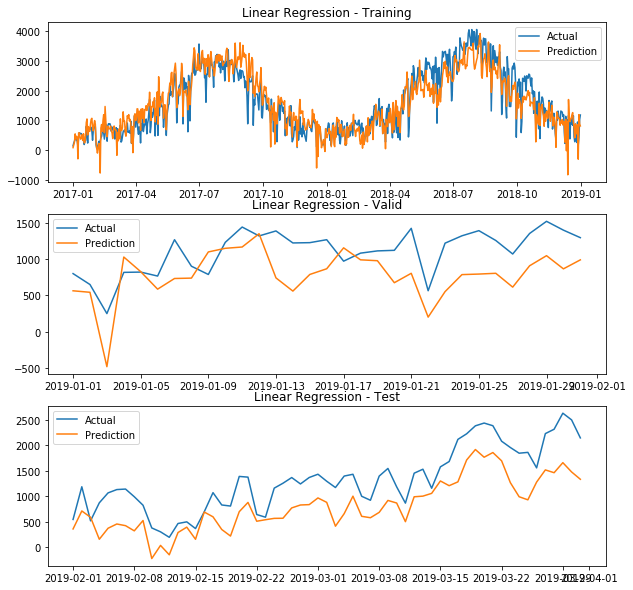

In [16]:
model_name = 'Linear Regression'
model = lin_reg_model_sm


lin_score = custom_plot_package('Linear Regression', lin_reg_model_sm, X_train_c, X_valid_c, X_test_c, y_train, y_valid, y_test)
custom_score_display(lin_score)

### Random Forest

In [17]:
from sklearn.ensemble import RandomForestRegressor

#RF_model =  RandomForestRegressor(n_estimators=50, max_depth = 4, oob_score=True, min_samples_leaf=5)
RF_model = RandomForestRegressor(n_estimators=50, max_depth=10, oob_score=False, n_jobs=-1)
RF_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

,Training - RMSE,Valid - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,182.813686,388.337067,477.233092,0.968663,-0.702818,0.398264


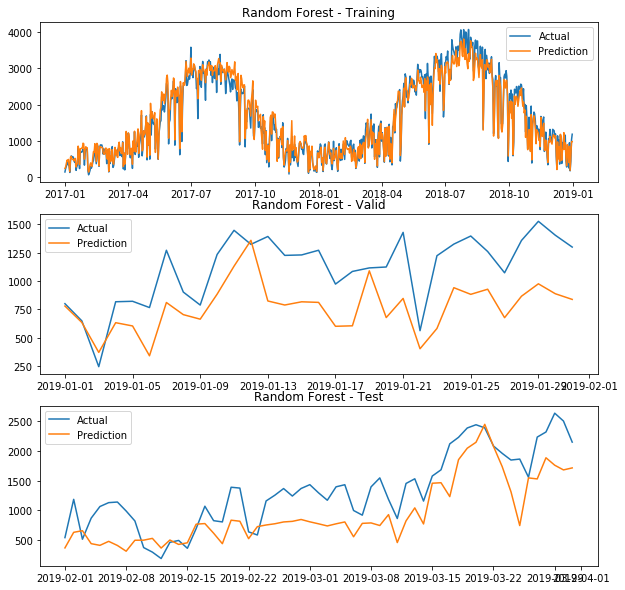

In [18]:
RF_score = custom_plot_package('Random Forest', RF_model, X_train, X_valid, X_test, y_train, y_valid, y_test)
custom_score_display(RF_score)

### XGBoost

In [19]:
from xgboost import XGBRegressor

XGB_model = XGBRegressor(learning_rate=.05, max_depth=4, 
                             n_estimators=200, gamma=0, 
                             subsample=0.9, colsample_bytree=0.7,
                             scale_pos_weight=1, min_child_weight=3,
                             reg_alpha=0.01)
XGB_model.fit(X_train, y_train)

[18:22:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=3, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9, verbosity=1)

,Training - RMSE,Valid - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,236.069992,377.174598,493.899273,0.947746,-0.606332,0.355502


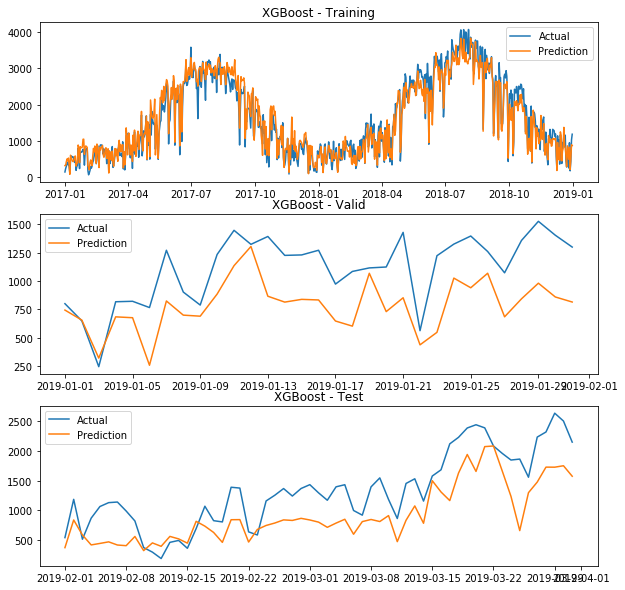

In [20]:
XGB_score = custom_plot_package('XGBoost', XGB_model, X_train, X_valid, X_test, y_train, y_valid, y_test)
custom_score_display(XGB_score)

### LightGBM

In [23]:
from lightgbm import LGBMRegressor

LGBM_model = LGBMRegressor(learning_rate=0.1,
                           max_depth=3, 
                           n_estimators=302, 
                           num_leaves=6,
                           reg_alpha=94,
                           reg_lambda=92
                          )
LGBM_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=3,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=302, n_jobs=-1, num_leaves=6, objective=None,
       random_state=None, reg_alpha=94, reg_lambda=92, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

,Training - RMSE,Valid - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,302.574415,386.498466,473.081048,0.914157,-0.686732,0.408689


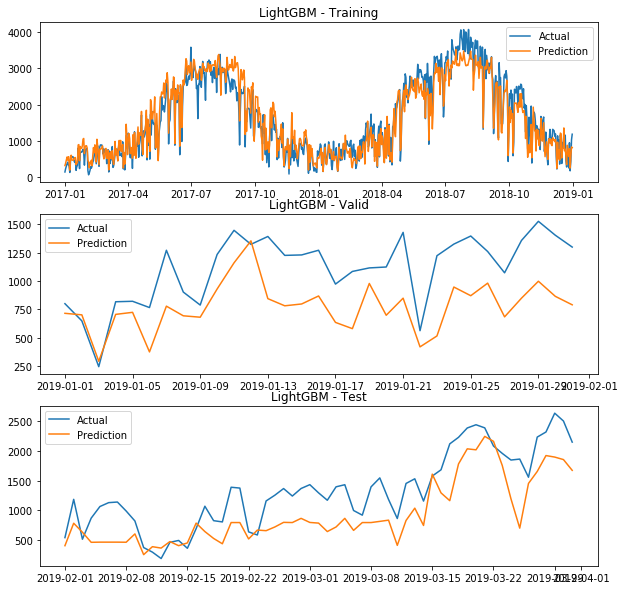

In [25]:
LGBM_score = custom_plot_package('LightGBM', LGBM_model, X_train, X_valid, X_test, y_train, y_valid, y_test)
custom_score_display(LGBM_score)

### CatBoost

In [21]:
from catboost import CatBoostRegressor
CB_model = CatBoostRegressor(learning_rate=0.01, 
                             max_depth=6, 
                             n_estimators=1500, 
                             l2_leaf_reg=4,
                             random_strength=0,
                             bagging_temperature=40,
                             task_type='GPU')

CB_model.fit(X_train, y_train)

0:	learn: 1904.2029591	total: 11.2ms	remaining: 16.8s
1:	learn: 1889.1047615	total: 23.3ms	remaining: 17.5s
2:	learn: 1874.1858214	total: 33.8ms	remaining: 16.9s
3:	learn: 1859.4447956	total: 44.4ms	remaining: 16.6s
4:	learn: 1844.8798662	total: 54.9ms	remaining: 16.4s
5:	learn: 1830.4895849	total: 65.4ms	remaining: 16.3s
6:	learn: 1816.2721177	total: 75.9ms	remaining: 16.2s
7:	learn: 1802.2259114	total: 86.4ms	remaining: 16.1s
8:	learn: 1788.3493147	total: 96.4ms	remaining: 16s
9:	learn: 1774.6410696	total: 106ms	remaining: 15.8s
10:	learn: 1759.0678478	total: 118ms	remaining: 16s
11:	learn: 1745.6681729	total: 128ms	remaining: 15.8s
12:	learn: 1732.4320635	total: 137ms	remaining: 15.7s
13:	learn: 1719.3575863	total: 147ms	remaining: 15.6s
14:	learn: 1706.4436270	total: 157ms	remaining: 15.5s
15:	learn: 1693.6885256	total: 166ms	remaining: 15.4s
16:	learn: 1681.0909439	total: 176ms	remaining: 15.4s
17:	learn: 1668.6490902	total: 185ms	remaining: 15.3s
18:	learn: 1656.3619219	total: 19

155:	learn: 867.9864401	total: 1.68s	remaining: 14.5s
156:	learn: 866.4731726	total: 1.69s	remaining: 14.4s
157:	learn: 864.9872594	total: 1.7s	remaining: 14.4s
158:	learn: 860.6408062	total: 1.71s	remaining: 14.4s
159:	learn: 859.2017959	total: 1.72s	remaining: 14.4s
160:	learn: 857.7888363	total: 1.73s	remaining: 14.4s
161:	learn: 856.4014933	total: 1.74s	remaining: 14.4s
162:	learn: 855.0392765	total: 1.75s	remaining: 14.4s
163:	learn: 853.7017413	total: 1.76s	remaining: 14.4s
164:	learn: 850.0974577	total: 1.78s	remaining: 14.4s
165:	learn: 848.8024634	total: 1.79s	remaining: 14.4s
166:	learn: 847.5310670	total: 1.8s	remaining: 14.4s
167:	learn: 846.2828829	total: 1.81s	remaining: 14.4s
168:	learn: 841.6698862	total: 1.82s	remaining: 14.4s
169:	learn: 840.4637989	total: 1.83s	remaining: 14.4s
170:	learn: 839.2798217	total: 1.84s	remaining: 14.3s
171:	learn: 838.1174992	total: 1.86s	remaining: 14.3s
172:	learn: 836.9765549	total: 1.87s	remaining: 14.3s
173:	learn: 835.8566043	total:

321:	learn: 701.6869223	total: 3.52s	remaining: 12.9s
322:	learn: 701.6232607	total: 3.53s	remaining: 12.9s
323:	learn: 700.6213133	total: 3.55s	remaining: 12.9s
324:	learn: 700.5601516	total: 3.56s	remaining: 12.9s
325:	learn: 699.6765437	total: 3.57s	remaining: 12.9s
326:	learn: 699.6176177	total: 3.58s	remaining: 12.8s
327:	learn: 699.5599713	total: 3.59s	remaining: 12.8s
328:	learn: 699.5033855	total: 3.6s	remaining: 12.8s
329:	learn: 699.4479545	total: 3.61s	remaining: 12.8s
330:	learn: 695.8234385	total: 3.63s	remaining: 12.8s
331:	learn: 695.4771142	total: 3.64s	remaining: 12.8s
332:	learn: 695.4248923	total: 3.65s	remaining: 12.8s
333:	learn: 695.3736750	total: 3.66s	remaining: 12.8s
334:	learn: 694.6951081	total: 3.67s	remaining: 12.8s
335:	learn: 694.6458248	total: 3.68s	remaining: 12.7s
336:	learn: 694.2713851	total: 3.69s	remaining: 12.7s
337:	learn: 692.4084629	total: 3.7s	remaining: 12.7s
338:	learn: 691.6297370	total: 3.71s	remaining: 12.7s
339:	learn: 691.5839750	total:

485:	learn: 637.9796192	total: 5.34s	remaining: 11.1s
486:	learn: 637.8972992	total: 5.35s	remaining: 11.1s
487:	learn: 637.8906678	total: 5.36s	remaining: 11.1s
488:	learn: 637.8466857	total: 5.37s	remaining: 11.1s
489:	learn: 637.8402256	total: 5.38s	remaining: 11.1s
490:	learn: 637.5754073	total: 5.39s	remaining: 11.1s
491:	learn: 637.5689788	total: 5.4s	remaining: 11.1s
492:	learn: 637.0891338	total: 5.41s	remaining: 11s
493:	learn: 637.0826316	total: 5.42s	remaining: 11s
494:	learn: 635.2650186	total: 5.43s	remaining: 11s
495:	learn: 635.2583942	total: 5.44s	remaining: 11s
496:	learn: 635.1630230	total: 5.45s	remaining: 11s
497:	learn: 635.1564320	total: 5.46s	remaining: 11s
498:	learn: 635.1499791	total: 5.47s	remaining: 11s
499:	learn: 634.8719901	total: 5.49s	remaining: 11s
500:	learn: 634.8657069	total: 5.5s	remaining: 11s
501:	learn: 634.8595616	total: 5.51s	remaining: 11s
502:	learn: 634.7817401	total: 5.53s	remaining: 11s
503:	learn: 634.7758357	total: 5.54s	remaining: 10.9

638:	learn: 600.5307789	total: 7.01s	remaining: 9.45s
639:	learn: 600.5255780	total: 7.03s	remaining: 9.44s
640:	learn: 600.4441461	total: 7.04s	remaining: 9.43s
641:	learn: 598.7522368	total: 7.05s	remaining: 9.42s
642:	learn: 598.7468008	total: 7.06s	remaining: 9.41s
643:	learn: 598.7022129	total: 7.07s	remaining: 9.4s
644:	learn: 598.6969229	total: 7.08s	remaining: 9.39s
645:	learn: 598.4588426	total: 7.09s	remaining: 9.37s
646:	learn: 598.4534955	total: 7.1s	remaining: 9.36s
647:	learn: 598.4481850	total: 7.11s	remaining: 9.35s
648:	learn: 598.4429660	total: 7.12s	remaining: 9.34s
649:	learn: 596.4065176	total: 7.14s	remaining: 9.33s
650:	learn: 596.4014829	total: 7.15s	remaining: 9.32s
651:	learn: 596.0837672	total: 7.16s	remaining: 9.31s
652:	learn: 596.0400832	total: 7.17s	remaining: 9.29s
653:	learn: 596.0348799	total: 7.18s	remaining: 9.29s
654:	learn: 596.0297501	total: 7.19s	remaining: 9.28s
655:	learn: 596.0247122	total: 7.2s	remaining: 9.27s
656:	learn: 596.0197845	total: 

801:	learn: 569.6440032	total: 8.82s	remaining: 7.68s
802:	learn: 568.7411718	total: 8.83s	remaining: 7.67s
803:	learn: 568.7005134	total: 8.85s	remaining: 7.66s
804:	learn: 568.6958115	total: 8.86s	remaining: 7.64s
805:	learn: 567.8152893	total: 8.87s	remaining: 7.63s
806:	learn: 567.7494914	total: 8.88s	remaining: 7.63s
807:	learn: 567.6898825	total: 8.89s	remaining: 7.62s
808:	learn: 566.2133583	total: 8.9s	remaining: 7.61s
809:	learn: 566.1927258	total: 8.92s	remaining: 7.59s
810:	learn: 566.1874998	total: 8.93s	remaining: 7.58s
811:	learn: 566.1823899	total: 8.94s	remaining: 7.57s
812:	learn: 566.1732926	total: 8.95s	remaining: 7.56s
813:	learn: 566.1682600	total: 8.96s	remaining: 7.55s
814:	learn: 566.0257025	total: 8.96s	remaining: 7.54s
815:	learn: 566.0019459	total: 8.98s	remaining: 7.52s
816:	learn: 565.9106469	total: 8.99s	remaining: 7.51s
817:	learn: 565.9055345	total: 9s	remaining: 7.5s
818:	learn: 565.9005382	total: 9.01s	remaining: 7.49s
819:	learn: 565.8761760	total: 9.

968:	learn: 539.6181298	total: 10.7s	remaining: 5.85s
969:	learn: 539.5416624	total: 10.7s	remaining: 5.84s
970:	learn: 539.5339034	total: 10.7s	remaining: 5.83s
971:	learn: 539.5316081	total: 10.7s	remaining: 5.82s
972:	learn: 539.5253114	total: 10.7s	remaining: 5.81s
973:	learn: 539.4633559	total: 10.7s	remaining: 5.8s
974:	learn: 539.4571802	total: 10.8s	remaining: 5.79s
975:	learn: 539.4549659	total: 10.8s	remaining: 5.78s
976:	learn: 539.4489324	total: 10.8s	remaining: 5.77s
977:	learn: 539.4414361	total: 10.8s	remaining: 5.76s
978:	learn: 539.0308096	total: 10.8s	remaining: 5.75s
979:	learn: 539.0188956	total: 10.8s	remaining: 5.74s
980:	learn: 538.4032201	total: 10.8s	remaining: 5.73s
981:	learn: 538.3163810	total: 10.8s	remaining: 5.72s
982:	learn: 538.2996263	total: 10.9s	remaining: 5.71s
983:	learn: 538.2933559	total: 10.9s	remaining: 5.7s
984:	learn: 538.2863728	total: 10.9s	remaining: 5.69s
985:	learn: 538.2802041	total: 10.9s	remaining: 5.68s
986:	learn: 537.2000673	total:

1126:	learn: 517.3823683	total: 12.5s	remaining: 4.14s
1127:	learn: 516.6837988	total: 12.5s	remaining: 4.13s
1128:	learn: 516.6747632	total: 12.6s	remaining: 4.12s
1129:	learn: 516.6658972	total: 12.6s	remaining: 4.11s
1130:	learn: 516.6572431	total: 12.6s	remaining: 4.1s
1131:	learn: 516.2285997	total: 12.6s	remaining: 4.09s
1132:	learn: 516.2266891	total: 12.6s	remaining: 4.08s
1133:	learn: 516.2198321	total: 12.6s	remaining: 4.07s
1134:	learn: 516.2113192	total: 12.6s	remaining: 4.06s
1135:	learn: 515.8686039	total: 12.6s	remaining: 4.05s
1136:	learn: 515.8501428	total: 12.7s	remaining: 4.04s
1137:	learn: 515.8482946	total: 12.7s	remaining: 4.03s
1138:	learn: 515.8420487	total: 12.7s	remaining: 4.02s
1139:	learn: 515.8333383	total: 12.7s	remaining: 4.01s
1140:	learn: 515.6645187	total: 12.7s	remaining: 4s
1141:	learn: 515.6584194	total: 12.7s	remaining: 3.99s
1142:	learn: 515.6495996	total: 12.7s	remaining: 3.98s
1143:	learn: 515.6409922	total: 12.7s	remaining: 3.96s
1144:	learn: 5

1276:	learn: 494.9986357	total: 14.5s	remaining: 2.53s
1277:	learn: 494.9810125	total: 14.5s	remaining: 2.52s
1278:	learn: 494.9785771	total: 14.5s	remaining: 2.51s
1279:	learn: 494.9685254	total: 14.5s	remaining: 2.5s
1280:	learn: 494.9522296	total: 14.6s	remaining: 2.49s
1281:	learn: 494.9507018	total: 14.6s	remaining: 2.48s
1282:	learn: 494.9408710	total: 14.6s	remaining: 2.46s
1283:	learn: 494.9312392	total: 14.6s	remaining: 2.45s
1284:	learn: 494.9263678	total: 14.6s	remaining: 2.44s
1285:	learn: 494.9168465	total: 14.6s	remaining: 2.43s
1286:	learn: 494.8486637	total: 14.6s	remaining: 2.42s
1287:	learn: 494.8393402	total: 14.6s	remaining: 2.41s
1288:	learn: 494.8373027	total: 14.7s	remaining: 2.4s
1289:	learn: 494.7593188	total: 14.7s	remaining: 2.39s
1290:	learn: 494.6730150	total: 14.7s	remaining: 2.38s
1291:	learn: 494.6637768	total: 14.7s	remaining: 2.37s
1292:	learn: 494.6472273	total: 14.7s	remaining: 2.35s
1293:	learn: 494.6450561	total: 14.7s	remaining: 2.34s
1294:	learn:

1438:	learn: 482.2639305	total: 16.5s	remaining: 701ms
1439:	learn: 482.2536592	total: 16.6s	remaining: 690ms
1440:	learn: 482.2383882	total: 16.6s	remaining: 678ms
1441:	learn: 482.2283208	total: 16.6s	remaining: 667ms
1442:	learn: 482.2280481	total: 16.6s	remaining: 655ms
1443:	learn: 482.2280254	total: 16.6s	remaining: 644ms
1444:	learn: 482.1412059	total: 16.6s	remaining: 632ms
1445:	learn: 482.1315230	total: 16.6s	remaining: 621ms
1446:	learn: 481.9567877	total: 16.6s	remaining: 609ms
1447:	learn: 481.9519671	total: 16.6s	remaining: 598ms
1448:	learn: 481.9516943	total: 16.7s	remaining: 587ms
1449:	learn: 481.9516488	total: 16.7s	remaining: 575ms
1450:	learn: 481.9443269	total: 16.7s	remaining: 564ms
1451:	learn: 481.9342989	total: 16.7s	remaining: 552ms
1452:	learn: 481.9244754	total: 16.7s	remaining: 541ms
1453:	learn: 481.6906755	total: 16.7s	remaining: 530ms
1454:	learn: 481.6810062	total: 16.8s	remaining: 518ms
1455:	learn: 481.6809835	total: 16.8s	remaining: 507ms
1456:	lear

,Training - RMSE,Valid - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,478.56446,262.121124,375.74615,0.785256,0.224192,0.626978


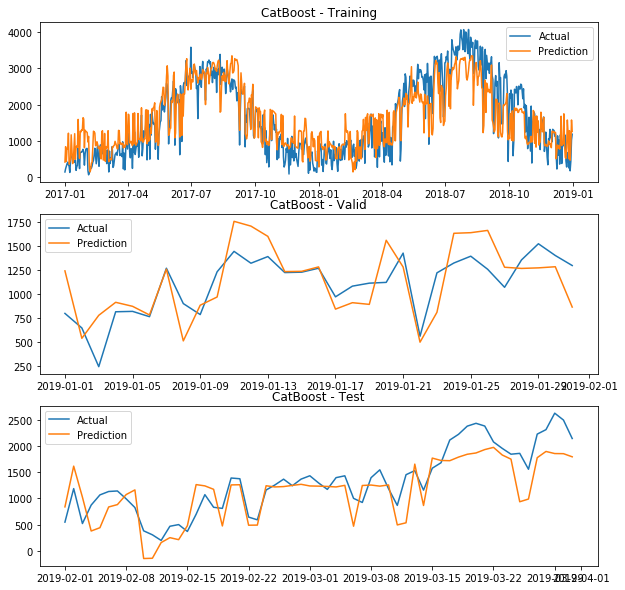

In [22]:
CB_score = custom_plot_package('CatBoost', CB_model, X_train, X_valid, X_test, y_train, y_valid, y_test)
custom_score_display(CB_score)

In [35]:
scores_combined = pd.DataFrame([lin_score, RF_score, XGB_score, LGBM_score, CB_score])
scores_combined.index = ['Lin Reg', 'RF', 'XGB', 'LightGBM', 'CatBoost']
scores_combined.columns = ['Training', 'Valid', 'Test', 'Training', 'Valid', 'Test']
scores_combined

,Training,Valid,Test,Training,Valid,Test
Lin Reg,404.757259,421.274793,558.745766,0.846386,-1.003925,0.175153
RF,182.813686,388.337067,477.233092,0.968663,-0.702818,0.398264
XGB,236.069992,377.174598,493.899273,0.947746,-0.606332,0.355502
LightGBM,302.574415,386.498466,473.081048,0.914157,-0.686732,0.408689
CatBoost,478.564460,262.121124,375.746150,0.785256,0.224192,0.626978
